In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# annoying warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

def mae(rf, X_val, y_val):
    return mean_absolute_error(y_val, rf.predict(X_val))

def r2(rf, X_val, y_val):
    return r2_score(y_val, rf.predict(X_val))

def mse(rf, X_val, y_val):
    return mean_squared_error(y_val, rf.predict(X_val))
        
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)

# RandomForest Model interpretation

Based on summary of models, we selected `no_tempinc.csv_w3` since it had the best r-squared and error metrics for both RandomForest and XGB models. This input did not use the created temperature increase variables, but did incorporate the sampling weights.

We will begin by generating the RandomForest model using our selected input. In the process we also incorporated a column of random numbers, with the intent of flagging any features that fall below the importance of a random numbers column.

In [10]:
#Set the random seed to match original model creations:
np.random.seed(42)

#Read in the best input:
df = pd.read_csv('p_data/no_tempinc.csv')
df.drop(['Unnamed: 0', 'CampaignID'], axis = 1, inplace = True)

train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

#Incorporate sampling weighing of 3 for the training set:
train = oversample_extremes(train, low_weight=3, high_weight = 3)

y_train = train['Quality']
train.drop(['Quality'], axis = 1, inplace = True)
X_train = train
X_train['Random'] = np.random.random(size=len(X_train))

y_val = val['Quality']
val.drop(['Quality'], axis = 1, inplace = True)
X_val = val
X_val['Random'] = np.random.random(size=len(X_val))

y_test = test['Quality']
test.drop(['Quality'], axis = 1, inplace = True)
X_test = test
X_test['Random'] = np.random.random(size=len(X_test))

rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                min_samples_split = 9,min_samples_leaf = 4,
                min_weight_fraction_leaf= 0.0)

rf_fit = rf_reg.fit(X_train, y_train)
rf_reg_preds_val = rf_fit.predict(X_val)
rf_reg_preds_test = rf_fit.predict(X_test)

mae = mean_absolute_error(y_test, rf_reg_preds_test)
mse = mean_squared_error(y_test, rf_reg_preds_test)
r_squared = r2_score(y_test, rf_reg_preds_test)
print("Test set R2:",round(r_squared,3))

mae = mean_absolute_error(y_val, rf_reg_preds_val)
mse = mean_squared_error(y_val, rf_reg_preds_val)
r_squared = r2_score(y_val, rf_reg_preds_val)
print("Validation set R2:",round(r_squared,3))



Test set R2: 0.346
Validation set R2: 0.548


### Default RandomForest feature_importance analysis

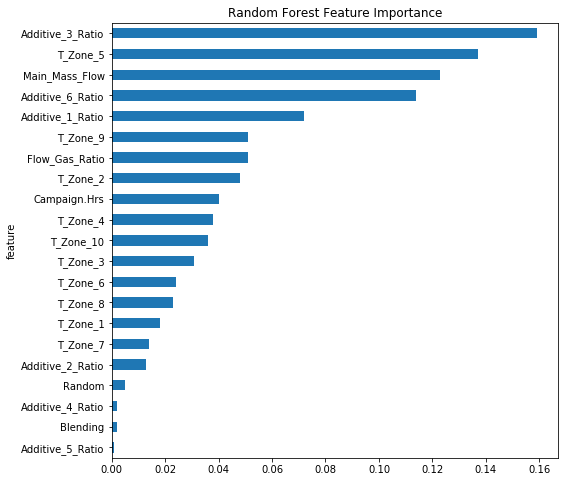

In [11]:
#Obtain feature importances from the model result and join back to features:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf_reg.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=True).set_index('feature')
importances.plot.barh(figsize=(8,8),legend=False, title="Random Forest Feature Importance")
#Reasonable results, random column is at the lower end of the scale

### Permutation importance analysis

In [12]:
def JBAFPI(rf, x_data, y_data, metric):
    """This function performs the permutation importance approach for model interpretation.
    The metric is the scoring function with which feature importances are calculated."""
    baseline = metric(rf,x_data,y_data)
    Importance = []
    feature = []
    for col in x_data.columns:
        save = x_data[col].copy()
        x_data[col] = np.random.permutation(x_data[col])
        m = metric(rf,x_data,y_data)
        x_data[col] = save
        Importance.append((m-baseline))
        feature.append(col)
    return pd.DataFrame({'Importance':Importance,'Feature':feature}).set_index("Feature")

In [13]:
np.random.seed(42) 
perm_imp_JBAFPI = JBAFPI(rf_reg, X_val, y_val, mae)
# display(perm_imp_JBAFPI)
perm_imp_JBAFPI = perm_imp_JBAFPI.sort_values('Importance',ascending=True)
perm_imp_JBAFPI.plot.barh(figsize=(8,8),legend=False, title="Random Forest Permutation Importance - MAE scoring")

TypeError: 'numpy.float64' object is not callable

## Tree stability

How robust are our results? How confident is our RandomForest model? Analyze the variance on the estimator results for a low, middle, and high quality data point to understand our model's stability 

In [ ]:

print(rf_reg_preds_test)